In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color                        # NOTE: additional package generativepy is required (pip)
from PIL import ImageColor

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm

# img_dir = './img/bivariate_maps/'
# if not exists(img_dir):
#     makedirs(img_dir)


# 1. Functions

## 1.1. Prepare DataFrames

In [ ]:
def shannon_entropy(row, region_cols):
    values = row[region_cols].to_numpy(dtype=float)
    total = values.sum()

    if total == 0:
        return 0
    
    p = values / total
    p = p[p > 0]  # filter out zero probabilities to avoid log(0)
    entropy = - np.sum(p * np.log(p))

    return entropy


def prepare_gdf(year, level):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlaceRegion/'
    file_extension = '_birthPlaceRegion_sex.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)

    # avoid data type issues
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place_Region'], as_index=False)['Value'].sum()

    # --- REMAP REGIONS INTO SMALLER SET ---
    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Northern Africa': 'MENA',
        'Western Asia': 'MENA',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',

        'Southern Asia': 'Asia',    # still not sure where to place it
    }
    df['Group'] = df['Birth_Place_Region'].map(region_map)
    # df['Group'] = df['Group'].fillna('Other') # assign 'Other' to unmapped regions

    df = df.groupby([level, 'Group'], as_index=False)['Value'].sum()

    # --- DATA PROCESSING SETUP ---
    # pivot table to have regions as columns
    df_wide = df.pivot_table(
        index=level,
        columns='Group',
        values='Value',
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    df_wide.columns.name = None

    # --- CALCULATE METRICS ---
    # total per region
    region_cols = df_wide.drop(columns=[level]).columns
    region_cols = df_wide.drop(columns=[level, 'Europe']).columns # NOTE: TEST TEST TEST - I STILL HAVE TO REMOVE LOCALS
    df_wide['Total_Immigrants'] = df_wide[region_cols].sum(axis=1)

    # dominant group
    df_wide['Dominant_Group'] = df_wide[region_cols].idxmax(axis=1)
    df_wide['Dominant_Group_Value'] = df_wide[region_cols].max(axis=1)
    df_wide['Dominant_Group_Share'] = (df_wide['Dominant_Group_Value'] / df_wide['Total_Immigrants'])#.replace([np.inf, np.nan], 0)

    # shannon entropy diversity index
    df_wide['Diversity'] = df_wide.apply(shannon_entropy, args=(region_cols,), axis=1)
    df_wide['Diversity_Norm'] = df_wide['Diversity'] / np.log(len(region_cols))

    # --- MERGE WITH GEOMETRY ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, df_wide, left_on=level, right_on=level, how='left')

    return df



## 1.2. Bivariate Map with Inset Legend

In [301]:
def hex_to_Color(hexcode):
    'convert hex color to Color object'

    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v / 256 for v in rgb]

    return Color(*rgb)


def plot_bivariate_inset(year, level, ax, n_div_bins=5):
    'x: dominant group (categorical)'
    'y: diversity normalized (numerical 0-1)'
    
    all_dominant_groups = ['Africa', 'MENA', 'Latin America', 'Europe', 'NA-AUS-NZ', 'Asia']

    gdf = prepare_gdf(year, level)

    # --- CATEGORICAL X AXIS ---
    group_to_index = {group: idx for idx, group in enumerate(all_dominant_groups)}
    gdf['group_idx'] = gdf['Dominant_Group'].map(group_to_index)

    n_x = len(all_dominant_groups)
    n_y = n_div_bins

    # --- NUMERICAL Y AXIS ---
    # bin edges
    div_bins = np.linspace(0, 1, n_div_bins+1)

    # binning
    gdf['div_bin'] = np.digitize(gdf['Diversity_Norm'], div_bins) - 1

    # clip to valid range
    gdf['div_bin'] = gdf['div_bin'].clip(0, n_div_bins-1)

    # --- GENERATE COLOR MATRIX ---
    # corner colors
    c00 = hex_to_Color('#f3f3f3')
    c10 = hex_to_Color('#e1a800')
    c01 = hex_to_Color('#8997c4')
    c11 = hex_to_Color('#000000')

    # interpolation grid
    color_matrix = []
    for i in range(n_y):
        row = []
        for j in range(n_x):
            # i = immigration axis, j = density axis
            col_low = c00.lerp(c10, j/(n_x-1) if n_x > 1 else 0)
            col_high = c01.lerp(c11, j/(n_x-1) if n_x > 1 else 0)
            col_final = col_low.lerp(col_high, i/(n_y-1) if n_y > 1 else 0)
            row.append(rgb2hex([col_final.r, col_final.g, col_final.b]))
        color_matrix.append(row)

    # --- ASSIGN COLORS ---
    gdf['Color'] = [color_matrix[div_bin][group_idx] for div_bin, group_idx in zip(gdf['div_bin'], gdf['group_idx'])]

    # --- PLOT MAP ---
    gdf.plot(ax=ax, color=gdf["Color"])
    gdf.boundary.plot(ax=ax, color="black", linewidth=0.4)
    ax.axis("off")

    # --- LEGEND AS MATRIX ---
    leg_ax = ax.inset_axes([0.75, 0.05, 0.22, 0.22])
    leg_ax.set_aspect("equal")

    for i in range(n_y):
        for j in range(n_x):
            rect = Rectangle((j, i), 1, 1)
            pc = PatchCollection([rect], facecolor=color_matrix[i][j])
            leg_ax.add_collection(pc)

    leg_ax.set_xlim(0, n_x)
    leg_ax.set_ylim(0, n_y)
    leg_ax.set_xticks(np.arange(n_x)+0.5)
    leg_ax.set_yticks(np.arange(n_y)+0.5)

    # labels
    leg_ax.set_xticklabels(all_dominant_groups, rotation=270, ha='right')
    leg_ax.set_yticklabels([f"{v:.2f}" for v in div_bins[:-1]])

    leg_ax.set_xlabel('Dominant Group', fontsize=8)
    leg_ax.set_ylabel('Diversity', fontsize=8)
    leg_ax.tick_params(labelsize=6)

    # --- SCATTER POINTS ON LEGEND ---
    scatter_ax = leg_ax.inset_axes([0, 0, 1, 1], zorder=10)
    scatter_ax.set_xlim(0, n_x)
    scatter_ax.set_ylim(0, n_y)
    scatter_ax.set_xticks([])
    scatter_ax.set_yticks([])

    # transparent background so the legend shows through the scatter points
    scatter_ax.set_facecolor((1,1,1,0)) 

    # accurate placement of scatter points on legend
    norm_x = gdf['group_idx'] + 0.5
    norm_y = gdf['div_bin'] + 0.5
    norm_y = gdf['Diversity_Norm'] * n_y
    scatter_ax.scatter(norm_x, norm_y, color='r', s=12, marker='x', alpha=0.9)



# 2. Plots

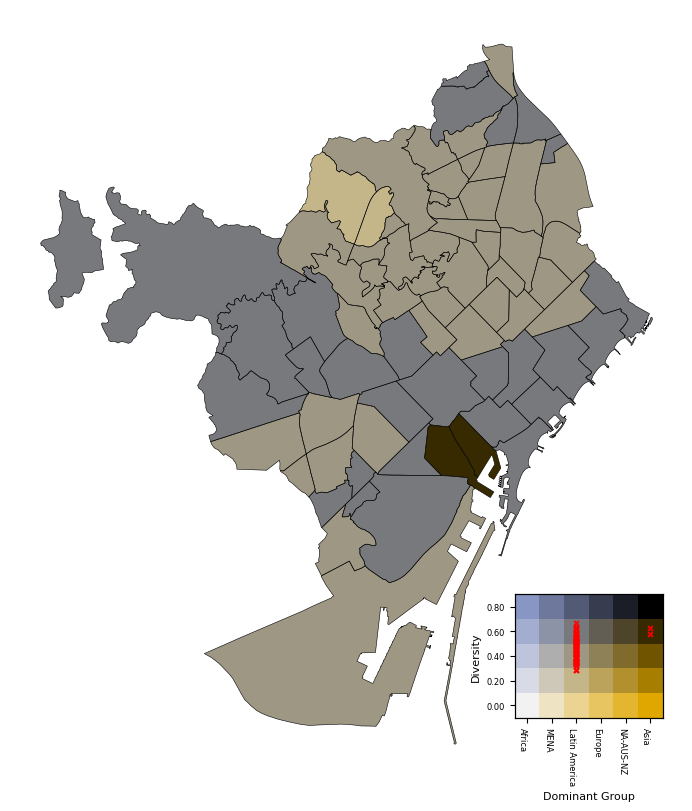

In [302]:
level = 'Neighborhood'

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_bivariate_inset(2025, level, ax, n_div_bins=5)

plt.show()


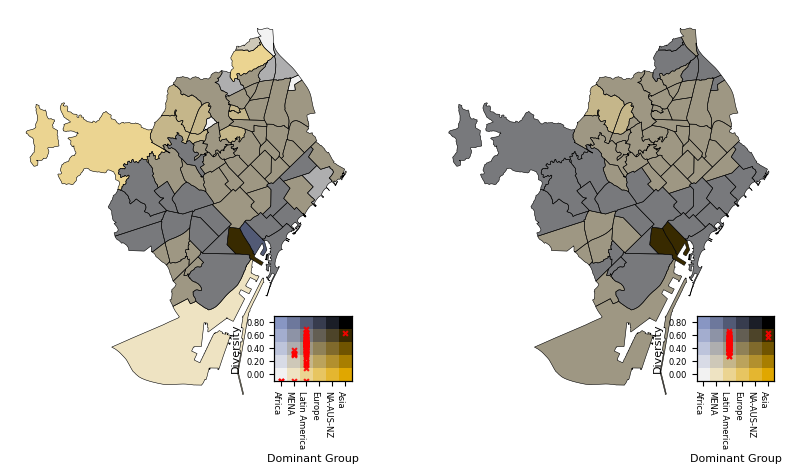

In [303]:
level = 'Neighborhood'

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plot_bivariate_inset(1997, level, ax[0], n_div_bins=5)
plot_bivariate_inset(2025, level, ax[1], n_div_bins=5)

plt.show()
